In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import os
import cv2
from sklearn.cluster import KMeans
from face import Face
from eye import Eye

In [75]:
import imagedb
db = imagedb.ImageDB('irisdb')

In [80]:
db.evaluate()

0.4

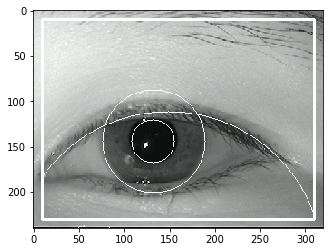

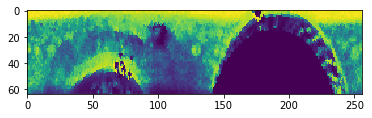

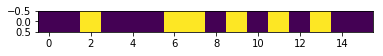

In [81]:
id_ = 0
imshow(db.faces[id_].canvas)
figure()
imshow(db.eyes[id_].iris.normalized)
figure()
imshow(db.eyes[id_].iris.bits_pattern_img)

In [77]:
removes = [4, 13, 14, 22, 23, 25, 26, 27, 28, 31, 32, 33, 34, 35, 39, 41, 42, 45, 46, 47, 48, 49, 82]
MAX = 83
db.data = delete(db.data[:MAX], removes, axis=0)
db.images = delete(db.images[:MAX], removes, axis=0)
db.bits = delete(db.bits[:MAX], removes, axis=0)

In [78]:
db.data.shape

(60, 2)

In [79]:
people, ids = unique(db.data[:, 0], return_inverse=True)
stds = []
for id_, person in enumerate(people):
    bits = db.bits[ids == id_]
    stds.append(bits.std(0))
    print(bits.std(0))
stds = array(stds).mean(0)
stds.sort()
stds

[0.3        0.45825757 0.45825757 0.         0.45825757 0.
 0.45825757 0.48989795 0.5        0.45825757 0.         0.5
 0.48989795 0.48989795 0.48989795 0.48989795]
[0.         0.         0.         0.33071891 0.33071891 0.5
 0.4330127  0.         0.4330127  0.4330127  0.48412292 0.
 0.         0.48412292 0.5        0.33071891]
[0.         0.         0.         0.47140452 0.         0.47140452
 0.         0.         0.         0.         0.         0.47140452
 0.47140452 0.47140452 0.47140452 0.        ]
[0.5        0.48989795 0.45825757 0.48989795 0.3        0.
 0.         0.48989795 0.3        0.3        0.48989795 0.45825757
 0.         0.         0.         0.        ]
[0.        0.        0.4330127 0.        0.4330127 0.        0.
 0.4330127 0.        0.4330127 0.4330127 0.4330127 0.        0.4330127
 0.4330127 0.4330127]
[0.4330127 0.        0.        0.4330127 0.5       0.        0.4330127
 0.4330127 0.4330127 0.        0.4330127 0.4330127 0.        0.4330127
 0.        0.      

array([0.15125583, 0.16031212, 0.19106223, 0.22818106, 0.28849318,
       0.291243  , 0.29585275, 0.29902435, 0.30402876, 0.31057865,
       0.3162702 , 0.3253834 , 0.32650585, 0.34571413, 0.35746954,
       0.39821978])

In [60]:
r = db.estimateUser(db.bits[0])
(r[:] == db.data[0]).all(1).any()

(1, 2)


True

In [51]:
db.data[1:2].shape

(1, 2)

In [33]:
db.data[33]

array([37,  1])

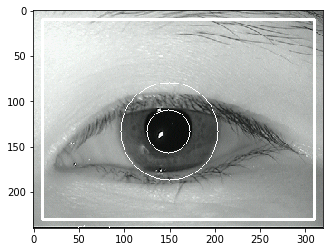

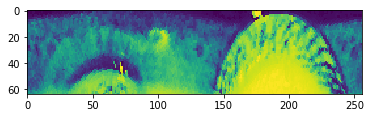

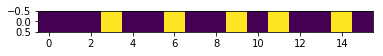

In [16]:
face = Face(db.images[1])
eye = Eye(face.frame, face.canvas, padding=10)
eye.draw(face)
imshow(face.canvas)
figure()
eye.iris.normalizeIris()
imshow(eye.iris.normalized)
figure()
imshow(eye.iris.bits_pattern_img)

In [12]:
eye.iris.bits_pattern_img

array([[0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0]])

In [13]:
eye.iris.bits_pattern

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0])

In [3]:
def captureScreenshot():
    cam = cv2.VideoCapture(0)

    cv2.namedWindow("test")

    img_counter = 0

    while True:
        ret, frame = cam.read()
        cv2.imshow("test", frame)
        if not ret:
            break
        k = cv2.waitKey(1)

        if k%256 == 27:
            # ESC pressed
            print("Escape hit, closing...")
            break
        elif k%256 == 32:
            # SPACE pressed
            img_name = "opencv_frame_{}.png".format(img_counter)
            cv2.imwrite(img_name, frame)
            print("{} written!".format(img_name))
            img_counter += 1

    cam.release()

    cv2.destroyAllWindows()

In [4]:
filename = './photo_2019-02-25_14-42-55.jpg'
def readFile(filename, display=False):
    img = cv2.imread(filename)
    w, h = img.shape[0:2]
    img = cv2.resize(img, dsize=(h//4, w//4))
    
    if display:
        cv2.imshow('oeil', img[:,:,2])
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return np.copy(img)

In [5]:
def getSegmentation(src, channel=2, k=3, gray=False):

    if gray:
        red = cv2.cvtColor(src.astype('uint8'), cv2.COLOR_BGR2GRAY)
    else:
        red = src[:,:,channel]
    w, h = red.shape[0:2]
    raster_red = np.reshape(red, (1, red.size)).squeeze()
    km = KMeans(n_clusters=k).fit(raster_red.reshape(-1,1))
    segm = km.labels_.reshape(w, h)
    idx = np.argsort(km.cluster_centers_.sum(axis=1))
    lut = np.zeros_like(idx)
    lut[idx] = np.arange(k)
    return np.copy(lut[segm])

In [6]:
def reduceNoise(src):
    normalizedImg = np.zeros_like(src)
    normalizedImg = cv2.normalize(src,  normalizedImg, 0, 2, cv2.NORM_MINMAX)
    kernel = np.ones((3,3),np.uint8)
    erosion = cv2.morphologyEx(normalizedImg.astype('int16'),cv2.MORPH_OPEN,kernel)
    erosion = cv2.morphologyEx(erosion.astype('int16'),cv2.MORPH_CLOSE,kernel)
    #imshow(erosion, cmap='Greys_r')
    return np.copy(erosion)

In [7]:
def getEdges(src):
    #sobelx = cv2.Sobel(src.astype('uint8'),cv2.CV_8U,1,0)
    sobelx = cv2.Canny(src.astype('uint8'),2,1)
    return sobelx

In [8]:
def drawCircle(src, img):
    circles = cv2.HoughCircles(src.astype('uint8'),cv2.HOUGH_GRADIENT,1,200,
                                param1=50,param2=30,minRadius=0,maxRadius=0)

    if circles is not None:
        canvas = np.copy(img)
        circles = np.uint16(np.around(circles))
        for i in circles[0,:]:
            # draw the outer circle
            cv2.circle(canvas,(i[0],i[1]),i[2],(0,255,0),2)
            # draw the center of the circle
            cv2.circle(canvas,(i[0],i[1]),2,(0,0,255),3)

        cv2.imshow('segmentation', canvas.astype('uint8'))

In [9]:
keep_loop=True
i = 0
while(keep_loop):
    i+=1
    print(i,end='\r')
    pressed_key = cv2.waitKey(1)
    img = readFile(filename)
    segm = getSegmentation(img).astype('int8')
    erosion = reduceNoise(segm)
    edges = getEdges(erosion)
    drawCircle(edges, img)
    if pressed_key & 0xFF == ord('\r'):
        keep_loop =False
cv2.destroyAllWindows()
#imshow(segm, cmap='Greys_r');

In [10]:
cv2.imshow('segmentation', (erosion*127).astype('uint8'))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [11]:
from data_collector import DataCollector
from image import Image
from face import Face
from eye import Eye
from data import Dataset
from classifier import Classifier
from buffer import Buffer

matplotlib.use('TkAgg')


class IrisDirection(object):
    """Main class, retriving video frames from the webcam, acquiring data and estimating the look direction
    """
    ROLLING_WINDOW_LENGTH = 3

    def __init__(self):
        self.dataset = Dataset()
        self.cap = None

        self.showMoments = False
        self.showEvaluation = False

        self.bufferFace = Buffer(self.ROLLING_WINDOW_LENGTH)
        self.bufferLeftEye = Buffer(self.ROLLING_WINDOW_LENGTH)
        self.bufferRightEye = Buffer(self.ROLLING_WINDOW_LENGTH)

    def startCapture(self):
        """Start the webcam recording
        """
        self.cap = cv2.VideoCapture(0)

    def stopCapture(self):
        """Stop the camera recording
        """
        # When everything done, release the capture
        self.cap.release()
        cv2.destroyAllWindows()

    def run(self):
        """Main loop
        """
        self.startCapture()

        keepLoop = True
        while keepLoop:
            pressed_key = cv2.waitKey(1)

            img = self.getCameraImage()
            face, left_eye, right_eye = img.detectEyes(self.bufferFace, self.bufferLeftEye, self.bufferRightEye)
            if face:
                face.draw(img)
            if left_eye:
                left_eye.draw(face)
                                
                segm = getSegmentation(left_eye.frame).astype('int8')
                erosion = reduceNoise(segm)
                edges = getEdges(erosion)
                drawCircle(edges, left_eye.frame)
                
            if right_eye:
                right_eye.draw(face)

            # Controls
            if pressed_key & 0xFF == ord('\x1b'):
                keepLoop = False

        self.stopCapture()

    def fig2cv(self, fig):
        """Convert a matplotlib figure to a cv2 image that can be displayed

        Args:
            fig (plt.Figure): Original matplotlib figure

        Returns:
            cv2.Image: Converted cv2 image

        """
        fig.canvas.draw()
        img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        # img is rgb, convert to opencv's default bgr
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        return img

    def getCameraImage(self):
        """Retrieves the current frame from the webcam

        Returns:
            Image: Image frame captured
        """
        # Capture frame-by-frame
        ret, frame = self.cap.read()
        frame = cv2.resize(frame, (640,480))
        frame = cv2.flip(frame, 1)

        return Image(frame)


1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  if __name__ == '__main__':


In [12]:
ed = IrisDirection()
ed.run()

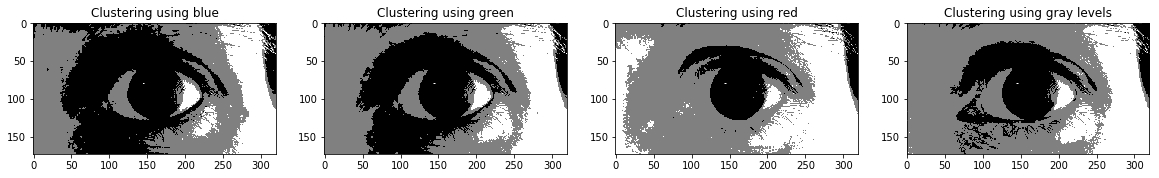

In [62]:
figure(figsize=(20,5))
k=3
img = readFile(filename)
color_lut=['blue', 'green', 'red']
for chan in range(3):
    segm = getSegmentation(img, channel=chan, k=k).astype('int8')
    subplot(1,4,chan+1)
    imshow(segm, cmap='gray')
    title('Clustering using {}'.format(color_lut[chan]))
segm = getSegmentation(img, k=k, gray=True).astype('int8')
subplot(1,4,4)
imshow(segm, cmap='gray')
title('Clustering using gray levels')

show();

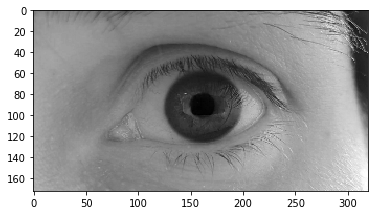

In [15]:
imshow(img[:,:,2], cmap='gray')

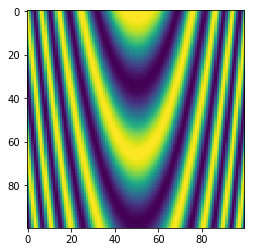

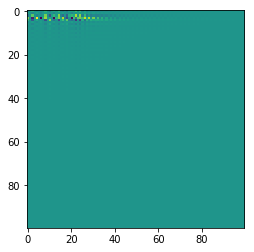

In [44]:
from scipy.fftpack import dct, idct
x = np.arange(-5, 5, 0.1)
y = np.arange(-5, 5, 0.1)
xx, yy = np.meshgrid(x, y, sparse=True)
z = np.sin(xx**2 + yy)
imshow(z)
figure()
d = dct(dct(z.T, norm='ortho').T, norm='ortho')
imshow(d)

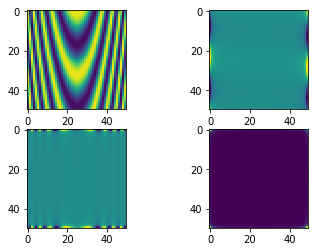

In [51]:
for i in range(2):
    for j in range(2):
        subplot(2,2,i*2+j+1)
        imshow(idct(idct(d[i*50:(i+1)*50,j*50:(j+1)*50], norm='ortho').T, norm='ortho').T)

In [59]:
def function(a: int) -> None:
    print(a)

In [61]:
function(.5)

0.5


0.5